# Simple Atmospheric Model

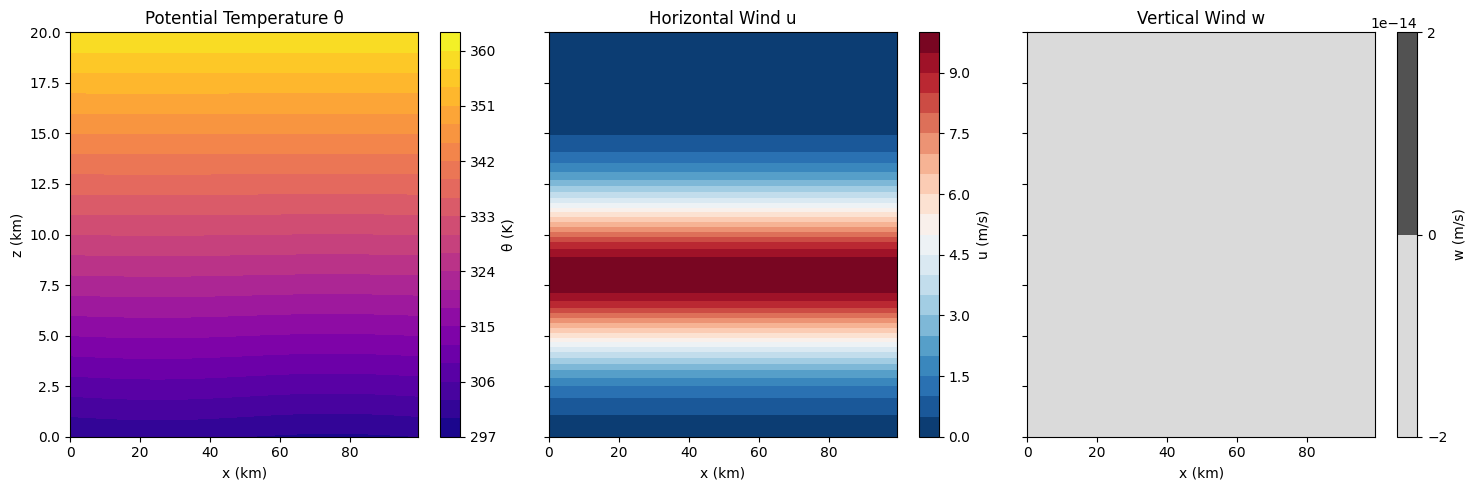

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Domain definition (km -> m for physics)
# ------------------------------------------------------------
Lx_km = 100.0
Lz_km = 20.0

nx = 200      # horizontal points
nz = 80       # vertical points

x = np.linspace(0, Lx_km * 1e3, nx, endpoint=False)  # periodic
z = np.linspace(0, Lz_km * 1e3, nz)

X, Z = np.meshgrid(x, z, indexing="xy")

# ------------------------------------------------------------
# 2. Physical constants (minimal)
# ------------------------------------------------------------
g = 9.81            # m/s^2
theta_ref = 300.0  # K
dtheta_dz = 3e-3   # K/m (stable stratification)

# ------------------------------------------------------------
# 3. Initial fields
# ------------------------------------------------------------

# Potential temperature: stable linear stratification
theta = theta_ref + dtheta_dz * Z

# Add a small horizontal perturbation (wave-like)
theta += 0.5 * np.sin(2 * np.pi * X / (Lx_km * 1e3)) * np.exp(-(Z / 8000)**2)

# Horizontal wind: weak jet centered at mid-height
u0 = 10.0  # m/s
u = u0 * np.exp(-((Z - 8000.0) / 4000.0)**2)

# Vertical wind: initially zero
w = np.zeros_like(u)

# ------------------------------------------------------------
# 4. Plot initial state
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Potential temperature
cf = axes[0].contourf(
    X / 1e3, Z / 1e3, theta, levels=20, cmap="plasma"
)
plt.colorbar(cf, ax=axes[0], label="θ (K)")
axes[0].set_title("Potential Temperature θ")
axes[0].set_xlabel("x (km)")
axes[0].set_ylabel("z (km)")

# Horizontal wind
cf = axes[1].contourf(
    X / 1e3, Z / 1e3, u, levels=20, cmap="RdBu_r"
)
plt.colorbar(cf, ax=axes[1], label="u (m/s)")
axes[1].set_title("Horizontal Wind u")
axes[1].set_xlabel("x (km)")

# Vertical wind
cf = axes[2].contourf(
    X / 1e3, Z / 1e3, w, levels=10, cmap="Greys"
)
plt.colorbar(cf, ax=axes[2], label="w (m/s)")
axes[2].set_title("Vertical Wind w")
axes[2].set_xlabel("x (km)")

plt.tight_layout()
plt.savefig("atm_ic.png")
plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Clean initialization (overwrites everything)
# Domain: x in [0,100] km periodic, z in [0,20] km
# ============================================================

# Domain
Lx_km = 100.0
Lz_km = 20.0
nx = 200
nz = 80

x = np.linspace(0, Lx_km * 1e3, nx, endpoint=False)  # periodic
z = np.linspace(0, Lz_km * 1e3, nz)

X, Z = np.meshgrid(x, z, indexing="xy")

# Background stratification (potential temperature)
theta_ref = 300.0
dtheta_dz = 3e-3  # K/m stable
theta0_1d = theta_ref + dtheta_dz * z                  # (nz,)
theta0 = theta0_1d[:, None] * np.ones((1, nx))         # (nz,nx)

# Initial theta = theta0 + small perturbation
theta = theta0 + 0.5 * np.sin(2*np.pi*X/(Lx_km*1e3)) * np.exp(-(Z/8000.0)**2)

# Prescribed velocity for the passive tracer test (finite, simple, stable)
u0 = 10.0
u = u0 * np.exp(-((Z - 8000.0)/4000.0)**2)  # jet-like, depends on z only

w = np.zeros_like(u)  # no vertical motion for the passive-tracer sanity test

# Optional: save an IC plot (prefix atm_)
plt.figure(figsize=(7,4))
plt.contourf(X/1e3, Z/1e3, theta, levels=20, cmap="plasma")
plt.colorbar(label="θ (K)")
plt.xlabel("x (km)"); plt.ylabel("z (km)")
plt.title("atm_ initial θ")
plt.tight_layout()
plt.savefig("atm_ic.png", dpi=150)
plt.close()

# Hard sanity checks
print("Finite checks:",
      np.isfinite(u).all(), np.isfinite(w).all(), np.isfinite(theta).all(), np.isfinite(theta0).all())
print("Ranges: u", float(u.min()), float(u.max()),
      "| w", float(w.min()), float(w.max()),
      "| theta", float(theta.min()), float(theta.max()))


Finite checks: True True True True
Ranges: u 0.0012340980408667955 9.993592824182096 | w 0.0 0.0 | theta 299.5 360.0009652270681


In [3]:
import numpy as np

# ============================================================
# Safe derivatives: periodic in x, bounded in z (no wrap)
# ============================================================

def atm_ddx_central(f, dx):
    return (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2 * dx)

def atm_ddz_central(f, dz):
    df = np.zeros_like(f)
    df[1:-1, :] = (f[2:, :] - f[:-2, :]) / (2 * dz)
    df[0, :] = 0.0
    df[-1, :] = 0.0
    return df

def atm_laplacian_safe(f, dx, dz):
    lap = np.zeros_like(f)
    lap += (np.roll(f, -1, axis=1) - 2*f + np.roll(f, 1, axis=1)) / dx**2
    lap[1:-1, :] += (f[2:, :] - 2*f[1:-1, :] + f[:-2, :]) / dz**2
    return lap

# ============================================================
# Tridiagonal solver (Thomas)
# ============================================================

def atm_tridiag_solve(a, b, c, d):
    n = len(b)
    ac = a.astype(np.complex128, copy=True)
    bc = b.astype(np.complex128, copy=True)
    cc = c.astype(np.complex128, copy=True)
    dc = d.astype(np.complex128, copy=True)

    for i in range(1, n):
        denom = bc[i-1]
        if denom == 0:
            denom = 1e-30 + 0j
        m = ac[i] / denom
        bc[i] -= m * cc[i-1]
        dc[i] -= m * dc[i-1]

    x = np.empty(n, dtype=np.complex128)
    denom = bc[-1]
    if denom == 0:
        denom = 1e-30 + 0j
    x[-1] = dc[-1] / denom

    for i in range(n-2, -1, -1):
        denom = bc[i]
        if denom == 0:
            denom = 1e-30 + 0j
        x[i] = (dc[i] - cc[i]*x[i+1]) / denom

    return x

# ============================================================
# Pressure solve: ∇²p = (1/dt) div
# Periodic x via FFT, bounded z via tridiagonal with Neumann BC.
# Robust compatibility handling for kx=0.
# ============================================================

def atm_pressure_solve(div, dt, dx, dz):
    nz, nx = div.shape
    rhs_hat = np.fft.fft(div, axis=1) / dt
    kx = 2.0 * np.pi * np.fft.fftfreq(nx, d=dx)

    p_hat = np.zeros_like(rhs_hat, dtype=np.complex128)
    inv_dz2 = 1.0 / (dz * dz)

    for j in range(nx):
        k2 = kx[j] * kx[j]
        rhs = rhs_hat[:, j].astype(np.complex128)

        # kx=0 Neumann compatibility: enforce zero mean RHS in z
        if j == 0:
            rhs = rhs - np.mean(rhs)

        a = np.zeros(nz, dtype=np.complex128)
        b = np.zeros(nz, dtype=np.complex128)
        c = np.zeros(nz, dtype=np.complex128)

        # interior stencil
        a[1:-1] = inv_dz2
        b[1:-1] = -2.0 * inv_dz2 - k2
        c[1:-1] = inv_dz2

        # Neumann BCs
        b[0]  = -2.0 * inv_dz2 - k2
        c[0]  =  2.0 * inv_dz2
        a[-1] =  2.0 * inv_dz2
        b[-1] = -2.0 * inv_dz2 - k2

        # Fix gauge for kx=0: p(z=0)=0
        if j == 0:
            b[0] = 1.0 + 0j
            c[0] = 0.0 + 0j
            rhs[0] = 0.0 + 0j

        p_hat[:, j] = atm_tridiag_solve(a, b, c, rhs)

    p = np.fft.ifft(p_hat, axis=1).real
    return p

# ============================================================
# Projection operator
# ============================================================

def atm_project(u, w, dt, dx, dz):
    div = atm_ddx_central(u, dx) + atm_ddz_central(w, dz)
    p = atm_pressure_solve(div, dt, dx, dz)
    u_corr = u - dt * atm_ddx_central(p, dx)
    w_corr = w - dt * atm_ddz_central(p, dz)
    w_corr[0, :] = 0.0
    w_corr[-1, :] = 0.0
    return u_corr, w_corr, p


# ============================================================
# Tendencies: incompressible advection + diffusion + BUOYANCY
# ============================================================

def atm_tendencies_boussinesq(u, w, theta, theta0, dx, dz, nu, kappa, g=9.81, theta_ref=300.0):
    # Advection
    du_adv  = -(u * atm_ddx_central(u, dx) + w * atm_ddz_central(u, dz))
    dw_adv  = -(u * atm_ddx_central(w, dx) + w * atm_ddz_central(w, dz))
    dth_adv = -(u * atm_ddx_central(theta, dx) + w * atm_ddz_central(theta, dz))

    # Diffusion
    du_diff  = nu    * atm_laplacian_safe(u, dx, dz)
    dw_diff  = nu    * atm_laplacian_safe(w, dx, dz)
    dth_diff = kappa * atm_laplacian_safe(theta, dx, dz)

    # Buoyancy (PERTURBATION ONLY)
    theta_prime = theta - theta0
    dw_buoy = g * theta_prime / theta_ref

    du = du_adv + du_diff
    dw = dw_adv + dw_diff + dw_buoy
    dth = dth_adv + dth_diff

    # vertical boundary
    dw[0, :]  = 0.0
    dw[-1, :] = 0.0

    return du, dw, dth



In [4]:
import numpy as np

# ============================================================
# RK4 step with projection + buoyancy
# ============================================================

def atm_rk4_step_boussinesq(u, w, theta, theta0, dt, dx, dz, nu, kappa):
    # start projected
    u, w, _ = atm_project(u, w, dt, dx, dz)

    # k1
    du1, dw1, dth1 = atm_tendencies_boussinesq(
        u, w, theta, theta0, dx, dz, nu, kappa
    )

    # k2
    u2  = u     + 0.5*dt*du1
    w2  = w     + 0.5*dt*dw1
    th2 = theta + 0.5*dt*dth1
    w2[0,:]=0.0; w2[-1,:]=0.0
    u2, w2, _ = atm_project(u2, w2, dt, dx, dz)
    du2, dw2, dth2 = atm_tendencies_boussinesq(
        u2, w2, th2, theta0, dx, dz, nu, kappa
    )

    # k3
    u3  = u     + 0.5*dt*du2
    w3  = w     + 0.5*dt*dw2
    th3 = theta + 0.5*dt*dth2
    w3[0,:]=0.0; w3[-1,:]=0.0
    u3, w3, _ = atm_project(u3, w3, dt, dx, dz)
    du3, dw3, dth3 = atm_tendencies_boussinesq(
        u3, w3, th3, theta0, dx, dz, nu, kappa
    )

    # k4
    u4  = u     + dt*du3
    w4  = w     + dt*dw3
    th4 = theta + dt*dth3
    w4[0,:]=0.0; w4[-1,:]=0.0
    u4, w4, _ = atm_project(u4, w4, dt, dx, dz)
    du4, dw4, dth4 = atm_tendencies_boussinesq(
        u4, w4, th4, theta0, dx, dz, nu, kappa
    )

    # combine
    u_new  = u     + (dt/6.0)*(du1 + 2*du2 + 2*du3 + du4)
    w_new  = w     + (dt/6.0)*(dw1 + 2*dw2 + 2*dw3 + dw4)
    th_new = theta + (dt/6.0)*(dth1 + 2*dth2 + 2*dth3 + dth4)

    # final projection
    w_new[0,:]=0.0; w_new[-1,:]=0.0
    u_new, w_new, _ = atm_project(u_new, w_new, dt, dx, dz)

    return u_new, w_new, th_new


import time
import numpy as np

# ============================================================
# Run + store snapshots (with wall-clock timing)
# ============================================================

dx = (Lx_km * 1e3) / nx
dz = (Lz_km * 1e3) / (nz - 1)

dt = 5.0
hours = 2.0
nsteps = int(hours * 3600 / dt)

nu = 20.0
kappa = 10.0

# store every 10 minutes
stride = int(600 / dt)
snap_u = []
snap_w = []
snap_th = []
snap_t = []

t_wall_start = time.time()
t_wall_last  = t_wall_start

for n in range(1, nsteps + 1):
    u, w, theta = atm_rk4_step_boussinesq(
        u, w, theta, theta0, dt, dx, dz, nu, kappa
    )

    if n % stride == 0:
        snap_u.append(u.copy())
        snap_w.append(w.copy())
        snap_th.append(theta.copy())
        snap_t.append(n * dt)

    # progress + timing every 10 minutes of model time
    if n % int(600 / dt) == 0:
        t_now = time.time()
        elapsed = t_now - t_wall_start
        steps_done = n
        steps_left = nsteps - n
        sec_per_step = elapsed / steps_done
        eta = steps_left * sec_per_step

        print(
            f"t_model = {n*dt/3600:.2f} h | "
            f"max|w| = {np.max(np.abs(w)):.4f} m/s | "
            f"elapsed = {elapsed:.1f} s | "
            f"ETA ≈ {eta:.1f} s"
        )

print(f"✔ Boussinesq run finished in {time.time() - t_wall_start:.1f} s.")


t_model = 0.17 h | max|w| = 0.1885 m/s | elapsed = 14.8 s | ETA ≈ 163.3 s
t_model = 0.33 h | max|w| = 0.2223 m/s | elapsed = 29.5 s | ETA ≈ 147.6 s
t_model = 0.50 h | max|w| = 0.1803 m/s | elapsed = 43.9 s | ETA ≈ 131.7 s
t_model = 0.67 h | max|w| = 0.1338 m/s | elapsed = 58.6 s | ETA ≈ 117.2 s
t_model = 0.83 h | max|w| = 0.1072 m/s | elapsed = 73.5 s | ETA ≈ 102.9 s
t_model = 1.00 h | max|w| = 0.2126 m/s | elapsed = 88.0 s | ETA ≈ 88.0 s
t_model = 1.17 h | max|w| = 0.1226 m/s | elapsed = 103.0 s | ETA ≈ 73.5 s
t_model = 1.33 h | max|w| = 0.0582 m/s | elapsed = 117.8 s | ETA ≈ 58.9 s
t_model = 1.50 h | max|w| = 0.1745 m/s | elapsed = 132.4 s | ETA ≈ 44.1 s
t_model = 1.67 h | max|w| = 0.1338 m/s | elapsed = 147.0 s | ETA ≈ 29.4 s
t_model = 1.83 h | max|w| = 0.1110 m/s | elapsed = 161.5 s | ETA ≈ 14.7 s
t_model = 2.00 h | max|w| = 0.0775 m/s | elapsed = 175.8 s | ETA ≈ 0.0 s
✔ Boussinesq run finished in 175.8 s.


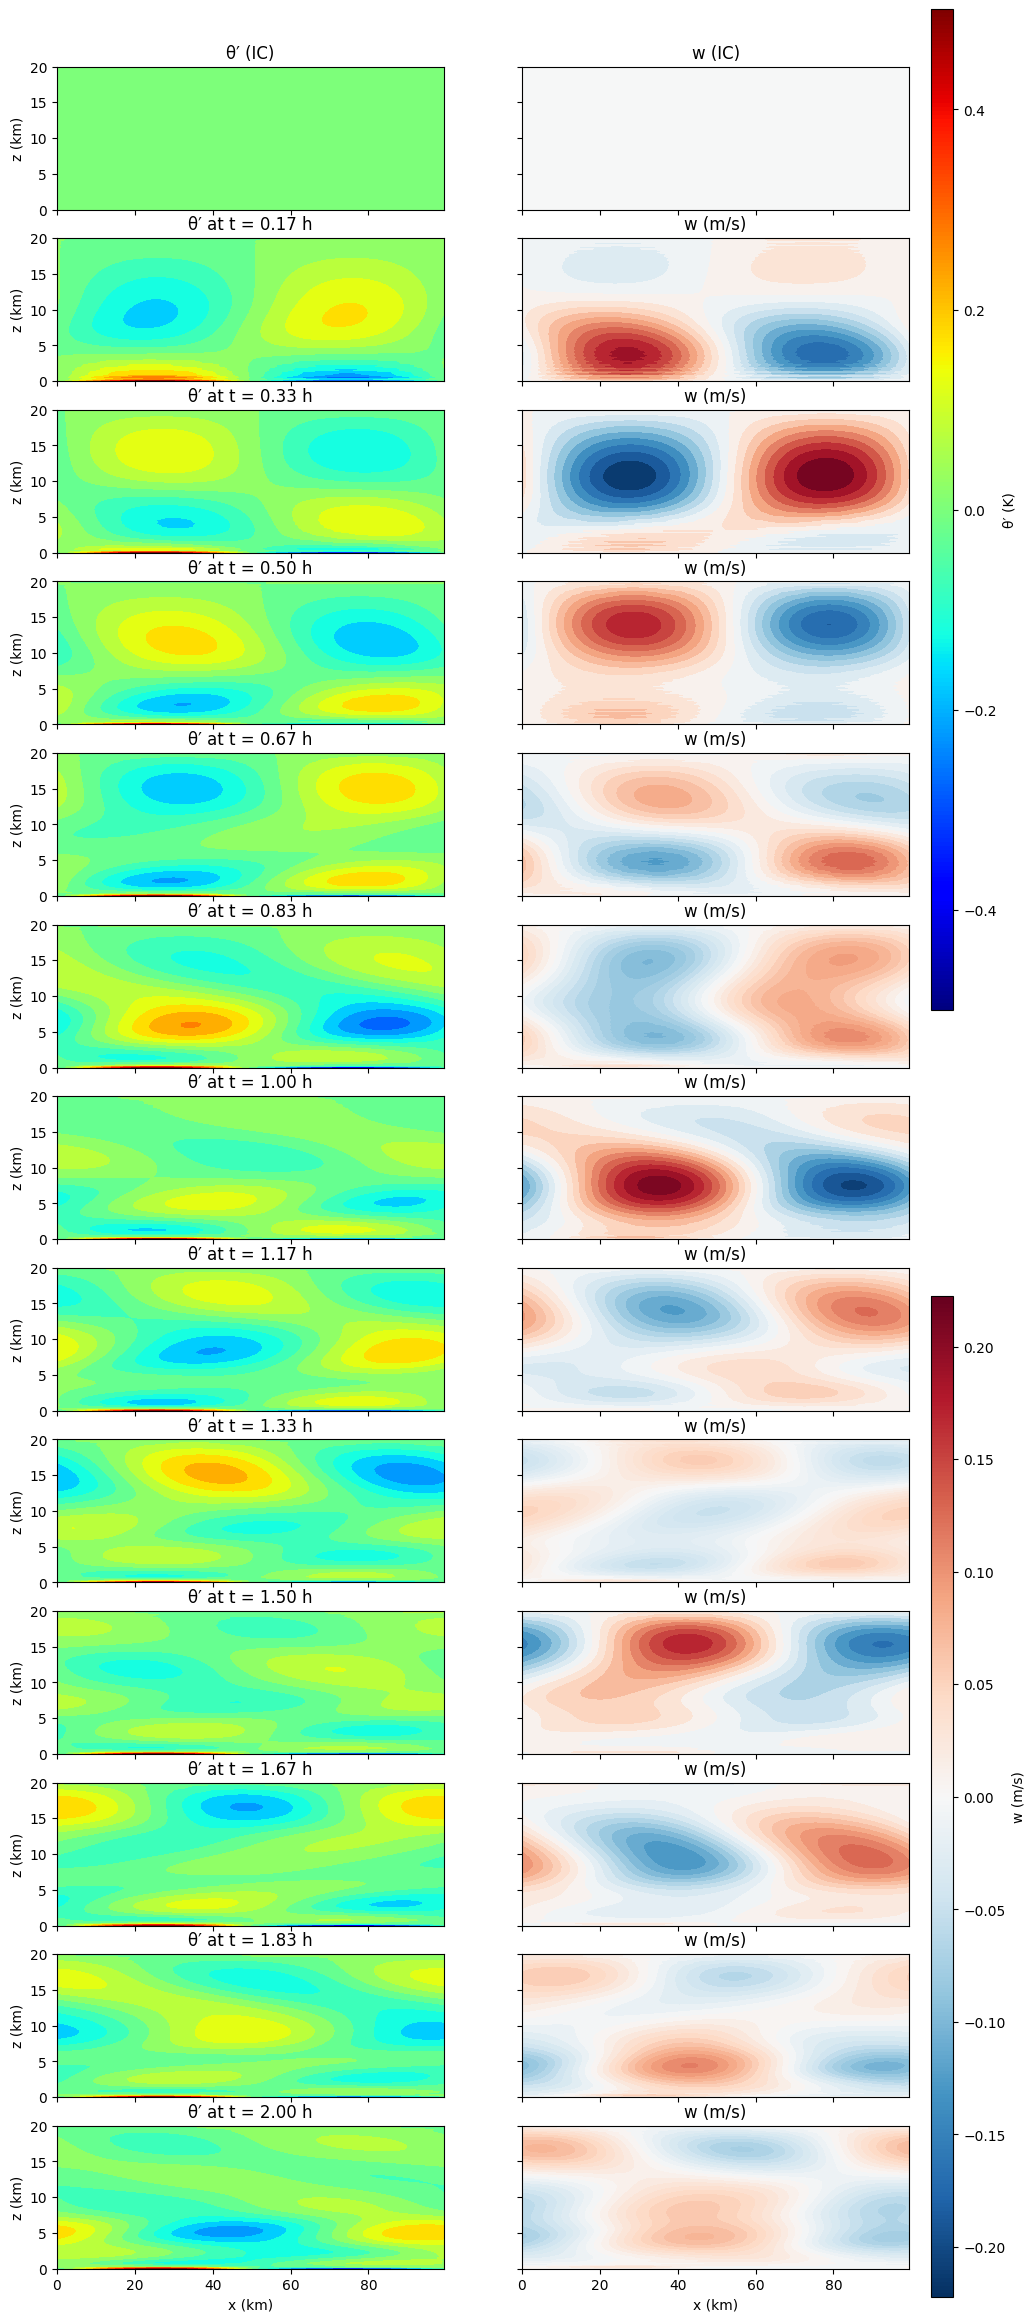

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# ============================================================
# Visualize gravity waves INCLUDING IC, with distinct colormaps
# ============================================================

X_km = X / 1e3
Z_km = Z / 1e3

# ------------------------------------------------------------
# Build plotting lists (prepend IC)
# ------------------------------------------------------------
plot_w  = [np.zeros_like(snap_w[0])] + snap_w
plot_th = [theta0] + snap_th
plot_t  = [0.0] + snap_t

# ------------------------------------------------------------
# Determine global limits
# ------------------------------------------------------------
thp_all = np.concatenate([(th - theta0).ravel() for th in plot_th])
w_all   = np.concatenate([w.ravel() for w in plot_w])

thp_min, thp_max = thp_all.min(), thp_all.max()
w_max = np.max(np.abs(w_all))

# Norms
norm_th = Normalize(vmin=thp_min, vmax=thp_max)
norm_w  = Normalize(vmin=-w_max, vmax=w_max)

# ------------------------------------------------------------
# Create figure
# ------------------------------------------------------------
nrows = len(plot_t)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=2,
    figsize=(11, 2.2 * nrows),
    sharex=True,
    sharey=True
)

for i, (w_i, th_i, t_i) in enumerate(zip(plot_w, plot_th, plot_t)):
    thp = th_i - theta0

    # θ′ panel (LEFT, scalar)
    ax = axes[i, 0]
    ax.contourf(
        X_km, Z_km, thp,
        levels=21,
        cmap="jet",
        norm=norm_th
    )
    ax.set_ylabel("z (km)")
    ax.set_title("θ′ (IC)" if t_i == 0.0 else f"θ′ at t = {t_i/3600:.2f} h")

    # w panel (RIGHT, signed)
    ax = axes[i, 1]
    ax.contourf(
        X_km, Z_km, w_i,
        levels=21,
        cmap="RdBu_r",
        norm=norm_w
    )
    ax.set_title("w (IC)" if t_i == 0.0 else "w (m/s)")

axes[-1, 0].set_xlabel("x (km)")
axes[-1, 1].set_xlabel("x (km)")

# ------------------------------------------------------------
# Colorbars via explicit ScalarMappables
# ------------------------------------------------------------
sm_th = ScalarMappable(norm=norm_th, cmap="jet")
sm_th.set_array([])

sm_w = ScalarMappable(norm=norm_w, cmap="RdBu_r")
sm_w.set_array([])

# θ′ colorbar (TOP)
cax_th = fig.add_axes([0.92, 0.55, 0.02, 0.35])
cb_th = fig.colorbar(sm_th, cax=cax_th)
cb_th.set_label("θ′ (K)")

# w colorbar (BOTTOM)
cax_w = fig.add_axes([0.92, 0.10, 0.02, 0.35])
cb_w = fig.colorbar(sm_w, cax=cax_w)
cb_w.set_label("w (m/s)")

plt.show()
